# Bandits with non-binary action spaces

## Application to dowblink power control in wireless networks

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
#print(constants.liter)
#print(scipy.__version__)
from scipy.sparse import csr_matrix
import cvxpy as cp
import random
from random import choices


## Problem formulation :

First of all we will work in this project on continuous-time Markov chains (instead of DTMC). Thus, only one event can occur in each time slot
#(1 package leaving or 1 arriving).

The gains are supposed fixed for now : for all i, $G_i = g_i$.

We will work on a simple example where there are only 2 mobile devices which receive and send data hence 2 random variables $X_1$ and $X_2$.

We assume : $X_i(t+1) = X_i(t) + A_i(t) - S_i(t)$ where the law of $A_i(t)$ is P($lambda_i$) and of $S_i(t)$ is $exp(mu_i)$ for all t.
Also, $X_1$ take its values in {0;$K_1$} and X_2 in {0;$K_2$} (max number of packets in th piles 1 & 2).

We will try to solve the system : $V((x_i,g_i),t+1) = sum(X_i(t+1)) + beta * M((x_i,g_i)->(x_i',g_i')) * V((x_i,g_i),t)$  (*)
The policy is fixed as we want to obtain the average cost for a given policy. $r_i = G_i*P_i*delta$ are arbitrarily fixed for now.



In [10]:
# Initialization variables : K1, K2, T, beta, Pm, mu_i, r_i, lambda_i, G
K1 = 15
K2 = 15
beta = 0.9

# Test with fixed gains and 2 random variables X1 and X2
r1 = 3
r2 = 5
delta = 0.05

# we define the flow function
def flow(g_i,P_i,delta):
    flow = np.log(1+g_i*P_i)
    #flow = g_i*P_i*delta
    #flow = np.exp(-g_i*P_i*delta)
    return flow

lambda1 = 3
lambda2 = 3
mu1 = 0.5*7
mu2 = 0.5*7
g1 = 20
g2 = 15

gamma = lambda1 + lambda2 + max(r1,r2)*(mu1 + mu2)  # normalization term + add a term epsilon 

# We assume the average cost is 0 at time t=0 (or t=T)
V0 = np.zeros((K1+1)*(K2+1))


In [11]:
# Let's build the matrices L_i, R_i, Theta_0, Theta_i and Theta_K_i :

def mat_L(mu_i,r_i,gamma_i,K_j):
    return np.eye(K_j+1)*mu_i*r_i/gamma_i

def mat_R(lambda_i,gamma_i,K_j):
    return np.eye(K_j+1)*lambda_i/gamma_i

def mat_theta0(mu_j,r_j,lambda_i,lambda_j,gamma_i,K_j):
    T = np.eye(K_j+1)
    T[0,0] = T[0,0] - (lambda_i+lambda_j)/gamma_i
    T[K_j,K_j] = T[K_j,K_j] - (lambda_i/gamma_i + mu_j*r_j/gamma_i)
    for i in range(K_j):
        T[i,i+1] = lambda_j/gamma_i
        T[i+1,i] = mu_j*r_j/gamma_i
        if i > 0 and i < K_j:
            T[i,i] = T[i,i] - ((lambda_i+lambda_j)/gamma_i + mu_j*r_j/gamma_i)
    return T

def mat_theta(mu_i,mu_j,r_i,r_j,lambda_i,lambda_j,gamma_i,K_j):
    T = mat_theta0(mu_j,r_j,lambda_i,lambda_j,gamma_i,K_j)
    T = T - np.eye(K_j+1)*mu_i*r_i/gamma_i
    return T

def mat_thetaK(mu_i,mu_j,r_i,r_j,lambda_i,lambda_j,gamma_i,K_j):
    T = mat_theta0(mu_j,r_j,lambda_i,lambda_j,gamma_i,K_j)
    T = T - np.eye(K_j+1)*(mu_i*r_i/gamma_i - lambda_i/gamma_i)
    return T

L = mat_L(mu1,r1,gamma,K2)
R = mat_R(lambda1,gamma,K2)
T0 = mat_theta0(mu2,r2,lambda1,lambda2,gamma,K2)
T = mat_theta(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)
TK = mat_thetaK(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)


# print("L = ")
# print(L)
# print("R = ")
# print(R)
# print("T_0 = ")
# print(T0)
#print("T_i = ")
#print(T)
#print("T_K = ")
#print(TK)



In [12]:
# Let's build the associated transition matrix M :

def mat_M(L,R,T0,T,TK,K_i,K_j):
    M = np.block([T0, R, np.zeros((K_j+1,(K_i-1)*(K_j+1)))])
    for i in range(1,K_i):
        M = np.block([[M],[np.zeros((K_j+1,(i-1)*(K_j+1))), L, T, R, np.zeros((K_j+1,(K_i-i-1)*(K_j+1)))]])
    M = np.block([[M],[np.zeros((K_j+1,(K_i-1)*(K_j+1))), L, TK]])
    return M

M = mat_M(L,R,T0,T,TK,K1,K2)
print(np.shape(M))
print('M = ')
print(M)
#print(np.sum(M, axis=1))


(256, 256)
M = 
[[0.85365854 0.07317073 0.         ... 0.         0.         0.        ]
 [0.42682927 0.42682927 0.07317073 ... 0.         0.         0.        ]
 [0.         0.42682927 0.42682927 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24390244 0.07317073 0.        ]
 [0.         0.         0.         ... 0.42682927 0.24390244 0.07317073]
 [0.         0.         0.         ... 0.         0.42682927 0.31707317]]


In [13]:
# Let's build the vector associated with the sum X_1 + X_2
x = [i for i in range(K2+1)]

def mat_X(x,K_i,K_j):
    X = np.zeros((K_i+1)*(K_j+1))
    for i in range(K_i+1):
        for j in range(K_j+1):
            X[j + (K_j+1)*i] = x[j]+i
    return X

X = mat_X(x,K1,K2)
print('X =', X)

eps = 0.01

def average_cost(M,X,V0,T):
    for t in range(T):
        V = 1/(t+1)*X + t/(t+1)*np.matmul(M,V0)
        V0 = V
    return V

def discounted_cost(beta,M,X,V0,eps):
    diff = 10
    t = 0
    while diff > eps:
        V = (1-beta)*(X + beta*np.matmul(M,V0))     # discounted cost
        #V = X + np.matmul(M,V0)
        diff = max(V-V0) - min(V-V0)
        V0 = V
        t += 1
    #print('Number of epochs to converge =',t)
    return V

T_tot = 1000
V_final_avg = average_cost(M,X,V0,T_tot)
print('Solution average cost =')
print(V_final_avg)
V_final_disc = discounted_cost(beta,M,X,V0,eps)
print('Solution discounted cost =')
print(V_final_disc)



X = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.  1.  2.
  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.  2.  3.  4.  5.
  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.  4.  5.  6.  7.  8.  9. 10. 11.
 12. 13. 14. 15. 16. 17. 18. 19.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.
 15. 16. 17. 18. 19. 20.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 10. 11.
 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 11. 12. 13. 14.
 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 15. 16. 17. 18. 19. 20

## Convergence of the solution (average cost)

Solution = 
[3.04252285 3.04437719 3.04808586 3.05364884 3.0610661  3.07033726
 3.0814603  3.09442327 3.10915624 3.12524993 3.14030858 3.0699148
 3.07176913 3.0754778  3.08104079 3.08845804 3.09772921 3.10885224
 3.12181521 3.13654818 3.15264188 3.16770052 3.12220259 3.12405692
 3.12776559 3.13332858 3.14074583 3.150017   3.16114004 3.174103
 3.18883598 3.20492967 3.21998831 3.19629749 3.19815182 3.20186049
 3.20742348 3.21484073 3.2241119  3.23523494 3.2481979  3.26293088
 3.27902457 3.29408321 3.2883774  3.29023174 3.2939404  3.29950339
 3.30692064 3.31619181 3.32731485 3.34027782 3.35501079 3.37110448
 3.38616312 3.39371274 3.39556707 3.39927574 3.40483873 3.41225598
 3.42152715 3.43265019 3.44561315 3.46034613 3.47643982 3.49149846
 3.50645096 3.50830529 3.51201396 3.51757695 3.5249942  3.53426536
 3.5453884  3.55835137 3.57308434 3.58917803 3.60423668 3.6193499
 3.62120424 3.62491291 3.63047589 3.63789315 3.64716431 3.65828735
 3.67125032 3.68598329 3.70207698 3.71713563 3.7234478

Text(0.5, 1.0, 'Evolution of the coefficients of the solution over time')

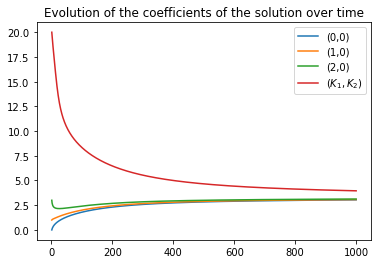

In [6]:
P1 = 10
P2 = 10
Pmax = P1 + P2 # total power budget in each time slot

# values of the flow for devices 1 & 2
r1 = flow(g1,P1,delta) #3
r2 = flow(g2,P2,delta) #2

# transition matrix :
L = mat_L(mu1,r1,gamma,K2)
R = mat_R(lambda1,gamma,K2)
T0 = mat_theta0(mu2,r2,lambda1,lambda2,gamma,K2)
T = mat_theta(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)
TK = mat_thetaK(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)

M = mat_M(L,R,T0,T,TK,K1,K2)
#print('M = ')
#print(M)

# solution :
V_final = average_cost(M,X,V0,T_tot)
print('Solution = ')
print(V_final)
#print(np.mean(V_final))

# convergence of the solution V_final :

def convergence(beta,M,X,V0,ind):
    res = []
    for i in range(1,1001):
        V_final = average_cost(M,X,V0,i)
        res.append(V_final[ind])
        #res.append(abs(V_final[ind]-min(V_final)))
    return res

def convergence_moy(beta,M,X,V0,K_i,K_j):
    res = np.zeros(1000)
    for i in range((K_i+1)*(K_j+1)):
        res = res + convergence(beta,M,X,V0,i)
    res = 1/((K_i+1)*(K_j+1)) * res
    return res


plt.figure()
plt.plot(range(1,1001),convergence(beta,M,X,V0,0), label='(0,0)')
plt.plot(range(1,1001),convergence(beta,M,X,V0,K2+1), label='(1,0)')
plt.plot(range(1,1001),convergence(beta,M,X,V0,2*(K2+1)+1), label='(2,0)')
plt.plot(range(1,1001),convergence(beta,M,X,V0,(K1+1)*(K2+1)-1), label='($K_1,K_2$)')
plt.legend()
plt.title('Evolution of the coefficients of the solution over time')

# plt.figure()
# plt.plot(range(1,1001),convergence_moy(beta,M,X,V0,K1,K2), label='Mean')
# plt.legend()
# plt.title('Evolution of the mean of the average cost over time')

# nmy=convergence(beta,M,X,V0,0)
# print(nmy[999])


## Stability of the system

Text(0.5, 1.0, 'Stability criterion : position of $\\lambda$ parameters')

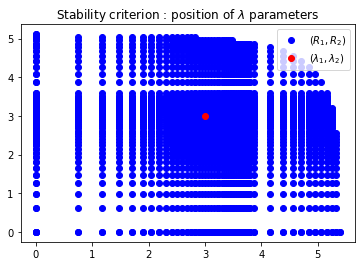

In [7]:
## Let's verify now that our system is stable with the chosen parameters
# The furthest the point (lambda1,lambda2) is from the boundary of the domain (R1,R2), the more stable the system will be

Pmax = 11
P1 = np.linspace(0,Pmax,15)
P1bis = np.linspace(0,Pmax/5,40)
P1 = np.concatenate((P1,P1bis),axis=None)
P2 = P1

#print('P1 =',P1)
#print('P2 =',P2)
R1 = np.log(1+g1*P1)
R2 = np.log(1+g2*P2)

plt.figure()
for i in range(len(P1)):        # loop on the policies
    for j in range(len(P2)):
        if P1[i]+P2[j] <= Pmax:
            plt.plot(R1[i],R2[j],'bo')
plt.plot(R1[0],R2[0],'bo',label='($R_1,R_2$)')
plt.plot(lambda1,lambda2,'ro',label='($\lambda_1,\lambda_2$)')
plt.legend()
plt.title('Stability criterion : position of $\lambda$ parameters')



## Optimal policy : Bellman method

In [14]:
Pmax = 11
P1 = np.linspace(0,Pmax,8)
P2 = np.linspace(0,Pmax,5)

R1 = np.log(1+g1*P1)
R2 = np.log(1+g2*P2)
gamma = lambda1 + lambda2 + np.log(1+max(g1,g2)*Pmax)*(mu1 + mu2)

# We assume the average cost is 0 at time t=0 (or t=T)
V0 = np.zeros((K1+1)*(K2+1))
policies = []
moyV_B = []
T_tot = 10000
diff = 10

eps = 0.01

#while diff > eps:
for t in range(T_tot):
    new_V = []
    for ind in range((K1+1)*(K2+1)):
        list_V = []   # matrix of V[ind] for every policy in a certain time slot t
        
        for i in range(len(P1)):        # loop on the policies
            for j in range(len(P2)):
                # we must satisfy the condition : P1+P2 <= Pmax

                if P1[i]+P2[j] <= Pmax:
                    # values of the flow for devices 1 & 2
                    r1 = R1[i] #flow(g1,P1[i],delta)
                    r2 = R2[j] #flow(g2,P2[j],delta)

                    # transition matrix :
                    L = mat_L(mu1,r1,gamma,K2)
                    R = mat_R(lambda1,gamma,K2)
                    T0 = mat_theta0(mu2,r2,lambda1,lambda2,gamma,K2)
                    T = mat_theta(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)
                    TK = mat_thetaK(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)
                    M = mat_M(L,R,T0,T,TK,K1,K2)
                    
                    # solution :
                    V = 1/(t+1)*X[ind] + t/(t+1)*np.matmul(M[ind,:],V0)
                    #V = X[ind] + np.matmul(M[ind],V0)
                    #val = abs(V-V0[ind])
                    #list_V.append(val)
                    list_V.append(V)
                else :
                    list_V.append(max(list_V)+1)   # the condition is not respected so we won't choose this policy
                
        policy = list_V.index(min(list_V))
        policies.append(policy+1)
        new_V.append(min(list_V))
        #new_V.append(min(list_V)+V0[ind])

    diff = max(new_V)-min(new_V)
    V0 = new_V
    moyV_B.append(np.mean(V0))

policies = np.reshape(policies,(T_tot,(K1+1)*(K2+1)))
policy_Bellman = policies[T_tot-1]
print('Last optimal policy :')
print(policy_Bellman)
#print(policies[(T_tot-1)*(K1+1)*(K2+1):T_tot*(K1+1)*(K2+1)])
policy_Bellman = policy_Bellman - np.ones(len(policy_Bellman))

S1 = V0
print('Solution :')
print(S1)

Last optimal policy :
[ 1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 36 18 18 18 18  9  9  9
  9  9  9  9  9  9  9  9 36 27 18 18 18 18 18 18 18  9  9  9  9  9  9  9
 36 27 18 18 18 18 18 18 18 18 18 18 18 18 18 18 36 27 27 18 18 18 18 18
 18 18 18 18 18 18 18 18 36 27 27 18 18 18 18 18 18 18 18 18 18 18 18 18
 36 27 27 27 18 18 18 18 18 18 18 18 18 18 18 18 36 27 27 27 18 18 18 18
 18 18 18 18 18 18 18 18 36 27 27 27 27 18 18 18 18 18 18 18 18 18 18 18
 36 27 27 27 27 27 18 18 18 18 18 18 18 18 18 18 36 27 27 27 27 27 18 18
 18 18 18 18 18 18 18 18 36 27 27 27 27 27 27 18 18 18 18 18 18 18 18 18
 36 27 27 27 27 27 27 18 18 18 18 18 18 18 18 18 36 27 27 27 27 27 27 27
 18 18 18 18 18 18 18 18 36 27 27 27 27 27 27 27 18 18 18 18 18 18 18 18
 36 27 27 27 27 27 27 18 18 18 18 18 18 18 18 18]
Solution :
[0.4004301254489313, 0.406509137918858, 0.4186610593540092, 0.43688131758044907, 0.46116168326498025, 0.4914753079699494, 0.5278064563745076, 0.5701468383933243, 0.6184915539403429, 0.672

## 2D / 3D representation of power allocations

[[ 0.         11.         11.         11.         11.         11.
  11.         11.         11.         11.         11.         11.
  11.         11.         11.         11.        ]
 [ 0.          4.71428571  7.85714286  7.85714286  7.85714286  7.85714286
   7.85714286  7.85714286  7.85714286  7.85714286  7.85714286  7.85714286
   7.85714286  7.85714286  7.85714286  7.85714286]
 [ 0.          4.71428571  4.71428571  4.71428571  7.85714286  7.85714286
   7.85714286  7.85714286  7.85714286  7.85714286  7.85714286  7.85714286
   7.85714286  7.85714286  7.85714286  7.85714286]
 [ 0.          4.71428571  4.71428571  4.71428571  4.71428571  4.71428571
   7.85714286  7.85714286  7.85714286  7.85714286  7.85714286  7.85714286
   7.85714286  7.85714286  7.85714286  7.85714286]
 [ 0.          4.71428571  4.71428571  4.71428571  4.71428571  4.71428571
   4.71428571  4.71428571  7.85714286  7.85714286  7.85714286  7.85714286
   7.85714286  7.85714286  7.85714286  7.85714286]
 [ 0.          1.5714

Text(0.5, 1.0, 'Evolution of $P_1^*$ and $P_2^*$ as a function of $X_2$ for $X_1=4$')

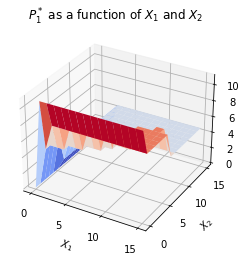

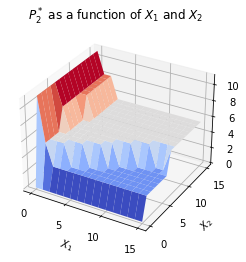

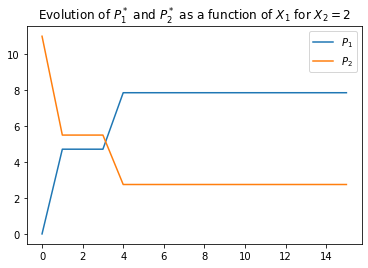

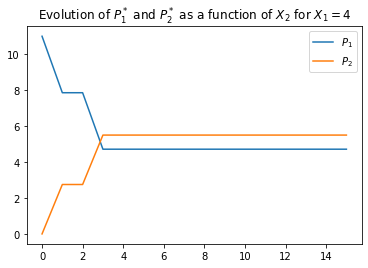

In [16]:
## Let's plot the graph of the allocated powers P1 and P2 in function of X1 and X2 :

from matplotlib.pyplot import xticks, yticks


X1 = [i for i in range(K1+1)]
X2 = [i for i in range(K2+1)]
last_policy = policies[T_tot-1]

# The values of P1 :
Pow1 = np.block([P1[(last_policy[0:(K2+1)]-last_policy[0:(K2+1)]%(len(P2)+1))//len(P2)]])
#print((last_policy[0:(K2+1)]%len(P2)))
for i in range(1,K1+1):
    Pow1 = np.block([[Pow1],[P1[(last_policy[i*(K2+1):(i+1)*(K2+1)]-(last_policy[i*(K2+1):(i+1)*(K2+1)]%len(P2)))//len(P2)]]])    # powers P1

Pow1 = np.transpose(Pow1)
print(Pow1)

# 3D plot :
x1, x2 = np.meshgrid(X1, X2)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x1, x2, Pow1, rstride=1, cstride=1,
                cmap='coolwarm', edgecolor='none')
ax.set_title('$P_1^*$ as a function of $X_1$ and $X_2$')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
xticks(np.linspace(0,K1,4))
yticks(np.linspace(0,K2,4))


# The values of P2 :
Pow2 = []
current_index = []
for k in range(K1+1):
    current_index.append(last_policy[k*(K2+1)]%len(P2)-1)
Pow2 = np.block([P2[current_index]])
for i in range(1,K2+1):
    current_index = []
    for k in range(K1+1):
        current_index.append(last_policy[k*(K2+1)+i]%len(P2)-1)
    Pow2 = np.block([[Pow2],[P2[current_index]]])

print(Pow2)

# 3D plot :
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x1, x2, Pow2, rstride=1, cstride=1,
                cmap='coolwarm', edgecolor='none')
ax.set_title('$P_2^*$ as a function of $X_1$ and $X_2$')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
xticks(np.linspace(0,K1,4))
yticks(np.linspace(0,K2,4))


# 2D plot :
poly11 = np.poly1d(np.polyfit(range(K1+1),Pow1[2],4))
poly12 = np.poly1d(np.polyfit(range(K1+1),Pow2[2],4))
poly21 = np.poly1d(np.polyfit(range(K1+1),Pow1[:,4],5))
poly22 = np.poly1d(np.polyfit(range(K1+1),Pow2[:,4],5))

plt.figure()
# plt.plot(np.linspace(0,K1,100), poly11(np.linspace(0,K1,100)), label='Approxim P1')
# plt.plot(np.linspace(0,K2,100), poly12(np.linspace(0,K2,100)), label='Approxim P2')
plt.plot(range(K1+1),Pow1[2], label='$P_1$')
plt.plot(range(K1+1),Pow2[2], label='$P_2$')
plt.legend()
plt.title('Evolution of $P_1^*$ and $P_2^*$ as a function of $X_1$ for $X_2=2$')

plt.figure()
# plt.plot(np.linspace(0,K1,100), poly21(np.linspace(0,K1,100)), label='Approxim P1')
# plt.plot(np.linspace(0,K2,100), poly22(np.linspace(0,K2,100)), label='Approxim P2')
plt.plot(range(K2+1),Pow1[:,4], label='$P_1$')
plt.plot(range(K2+1),Pow2[:,4], label='$P_2$')
plt.legend()
plt.title('Evolution of $P_1^*$ and $P_2^*$ as a function of $X_2$ for $X_1=4$')


In [10]:
print(lambda1/(mu1*np.log(1+g1*Pmax))+lambda2/(mu2*np.log(1+g2*Pmax)))
print(Pow1+Pow2)

0.3264572869584431
[[ 0.         11.         11.         11.         11.         11.
  11.         11.         11.         11.         11.        ]
 [11.         10.21428571 10.60714286 10.60714286 10.60714286 10.60714286
  10.60714286 10.60714286 10.60714286 10.60714286 10.60714286]
 [11.         10.21428571 10.21428571 10.21428571 10.60714286 10.60714286
  10.60714286 10.60714286 10.60714286 10.60714286 10.60714286]
 [11.         10.21428571 10.21428571 10.21428571 10.21428571 10.21428571
  10.60714286 10.60714286 10.60714286 10.60714286 10.60714286]
 [11.         10.21428571 10.21428571 10.21428571 10.21428571 10.21428571
  10.21428571 10.21428571 10.60714286 10.60714286 10.60714286]
 [11.          9.82142857 10.21428571 10.21428571 10.21428571 10.21428571
  10.21428571 10.21428571 10.21428571 10.21428571 10.21428571]
 [11.          9.82142857 10.21428571 10.21428571 10.21428571 10.21428571
  10.21428571 10.21428571 10.21428571 10.21428571 10.21428571]
 [11.          9.82142857 10.2

## Lower bound & Occupation measures

Linear programming : find the optimal occupation measure mu
We work with a fixed policy and we want to find the solution of the relaxed problem mu*. To do this we will solve a LP problem :

    $min C^T*mu$ (1)

    $A*mu < b$ (2)

    $mu = M*mu$ (3)

    forall i, $mu_i > 0$ and $mu_1 + mu_2 = 1$ (4)

https://www.cvxpy.org/examples/basic/linear_program.html

In [27]:
# First let's build the matrices C, A, b and d :
K1 = 10
K2 = 10

g1 = 20
g2 = 15

Pmax = 11
P1 = np.linspace(0,Pmax*3,20) #8
P2 = np.linspace(0,Pmax*3,20) #5
#print(P1)
#print(P2)

R1 = np.log(1+g1*P1)
R2 = np.log(1+g2*P2)
l1 = len(R1)
l2 = len(R2)

lambda1 = 3
lambda2 = 3
mu1 = 0.5*7
mu2 = 0.5*7

gamma = lambda1 + lambda2 + np.log(1+max(g1,g2)*Pmax)*(mu1 + mu2) # normalization term + add a term epsilon

# Matrix C for system (1) :
def mat_C(K_i,K_j,R_i,R_j):
    C = []
    for j in range(K_i+1):
        for k in range(len(R_i)):
            C.append(j)
    for j in range(K_j+1):
        for k in range(len(R_j)):
            C.append(j)
    return C

C = mat_C(K1,K2,R1,R2)
#print(C)

# Matrix A pfor system (2) :
def mat_A(K_i,K_j,P_i,P_j):
    A = []
    for j in range(K_i+1):
        A.extend(P_i)
    for j in range(K_j+1):
        A.extend(P_j)
    return A

A = mat_A(K1,K2,P1,P2)
#print(A)


# Matrix M for system (3) :
# Let's build Mat^T first
def mat_subM(K_i,mu_i,lambda_i,gamma_i,R_i):
    l_i = len(R_i)

    L_1 = np.ones((l_i,1))
    R_1 = np.ones((l_i,1))*lambda_i/gamma_i
    for i in range(l_i):
        L_1[i] = mu_i*R_i[i]/gamma_i
    T_01 = np.ones((l_i,1)) - R_1
    # print(T_01)
    # print(R_1)
    # print(np.zeros((l_i,(K_i-1))))
    T_i1 = np.ones((l_i,1)) - (R_1 + L_1)
    T_K1 = np.ones((l_i,1)) - L_1

    Mat1 = np.block([T_01, R_1, np.zeros((l_i,(K_i-1)))])
    for i in range(1,K_i):
        Mat1 = np.block([[Mat1],[np.zeros((l_i,(i-1))), L_1, T_i1, R_1, np.zeros((l_i,(K_i-i-1)))]])
    Mat1 = np.block([[Mat1],[np.zeros((l_i,(K_i-1))), L_1, T_K1]])
    return Mat1

Mat1 = mat_subM(K1,mu1,lambda1,gamma,R1)
Mat2 = mat_subM(K2,mu2,lambda2,gamma,R2)
Z1 = np.zeros((l1*(K1+1),(K2+1)))
Z2 = np.zeros((l2*(K2+1),(K1+1)))

Mat1 = np.concatenate((Mat1,Z1),axis=1)
Mat2 = np.concatenate((Z2,Mat2),axis=1)
subM = np.block([[Mat1],[Mat2]])

#print(subM)
#print(np.sum(subM, axis=1))
#print(np.shape(subM))

def mat_D(K_i,K_j,R_i,R_j):
    l_i = len(R_i)
    l_j = len(R_j)
    D = np.zeros(((K_i+1)*l_i+(K_j+1)*l_j,(K_i+1)+(K_j+1)))

    for i in range(K_i+1):
        D[i*l_i:(i+1)*l_i,i] = np.ones(l_i)
    for i in range(K_j+1):
        D[i*l_j+(K_i+1)*l_i:(i+1)*l_j+(K_i+1)*l_i,i+K_i+1] = np.ones(l_j)
    return D
D = mat_D(K1,K2,R1,R2)
#print(D)

# Matrice S pour le système (4) :

def mat_S(K_i,K_j,R_i,R_j):
    l_i = len(R_i)
    l_j = len(R_j)
    S = np.zeros((2,l_i*(K_i+1)+l_j*(K_j+1)))
    for i in range(l_i*(K_i+1)):
        S[0,i] = 1
    S[1] = 1-S[0]
    return S

S = mat_S(K1,K2,R1,R2)
#print(S)



In [28]:
# Solution of the LP :

n = len(C)
vect = [1,1]

Mu = cp.Variable(n)
objective = cp.Minimize(cp.matmul(C,Mu))
constraints = [cp.matmul(A,Mu) <= Pmax, cp.matmul(Mu,subM) == cp.matmul(Mu,D), cp.matmul(S,Mu) == vect, Mu >= 0]
problem = cp.Problem(objective, constraints)
solution = problem.solve()

Mu_val = Mu.value
for i in range(len(Mu_val)):
    if Mu_val[i] < 0:
        Mu_val[i]=0

# Print result.
print("The optimal value V is", problem.value)
print("A solution Mu is")
print(Mu_val)
print(np.shape(Mu_val))
#print("A dual solution is")
#print(problem.constraints[0].dual_value)

The optimal value V is 0.3122975887800744
A solution Mu is
[7.68001487e-01 2.62207366e-02 1.34218029e-02 9.12375146e-03
 6.98604197e-03 5.69260136e-03 4.81708663e-03 4.20487837e-03
 3.73160543e-03 3.35483135e-03 3.04784671e-03 2.79298950e-03
 2.57809806e-03 2.39452919e-03 2.23597094e-03 2.09769571e-03
 1.97610473e-03 1.86839691e-03 1.77236769e-03 1.68625377e-03
 2.56892861e-10 8.77500876e-11 4.77631510e-11 3.21643700e-11
 2.15673022e-11 1.49769087e-11 1.09788939e-11 8.37069032e-12
 6.58700105e-12 5.33222739e-12 4.44075396e-12 3.81691469e-12
 3.40765433e-12 3.19141109e-12 3.17884729e-12 3.43089352e-12
 4.12464604e-12 5.82692540e-12 1.14208095e-11 1.14572305e-01
 5.13561506e-10 1.75163950e-10 9.51084830e-11 6.38271264e-11
 4.25450161e-11 2.92682719e-11 2.11652554e-11 1.58273443e-11
 1.21193506e-11 9.44380624e-12 7.46056207e-12 5.96502574e-12
 4.83034731e-12 3.97891549e-12 3.37003404e-12 3.00155397e-12
 2.93830803e-12 3.44596287e-12 5.95185756e-12 1.51229659e-02
 7.69557375e-10 2.62407298

In [29]:
print('We find the initial value of Pmax :',np.matmul(A,Mu.value))
K = Mu.value
#print(np.reshape(K[0:l1*(K1+1)],(K1+1,l1)))

end = len(Mu.value)
#print(np.reshape(K[l1*(K1+1):end],(K2+1,l2)))
print(np.sum(Mu.value[0:l1*(K1+1)]))
print(np.sum(Mu.value[l1*(K1+1):end]))

We find the initial value of Pmax : 10.888631080616863
1.0000000059890624
1.0000000000357188


## OMR (Occupancy-Measured-Reward) Index Policy

In [30]:
Qui = Mu.value
for i in range(K1+1):
    norm = 0
    for j in range(l1):
        norm += Qui[j+i*l1]
    Qui[i*l1:(i+1)*l1] = Qui[i*l1:(i+1)*l1]/norm

for i in range(K2+1):
    norm = 0
    for j in range(l2):
        norm += Qui[j+i*l2+l1*(K1+1)]
    Qui[i*l2+l1*(K1+1):(i+1)*l2+l1*(K1+1)] = Qui[i*l2+l1*(K1+1):(i+1)*l2+l1*(K1+1)]/norm

Qui1 = Qui[0:l1*(K1+1)]
Qui2 = Qui[l1*(K1+1):end]

print(np.sum(Qui))
print('Qui1* =',np.reshape(Qui1,(K1+1,l1)))
print('Qui2* =',np.reshape(Qui2,(K2+1,l2)))

22.0
Qui1* = [[8.84789165e-01 3.02080452e-02 1.54628161e-02 1.05111729e-02
  8.04838838e-03 6.55825814e-03 5.54960652e-03 4.84430159e-03
  4.29905945e-03 3.86499048e-03 3.51132360e-03 3.21771102e-03
  2.97014169e-03 2.75865805e-03 2.57598833e-03 2.41668599e-03
  2.27660504e-03 2.15251841e-03 2.04188632e-03 1.94267732e-03]
 [2.24218985e-09 7.65892658e-10 4.16882168e-10 2.80734248e-10
  1.88241845e-10 1.30720147e-10 9.58250234e-11 7.30603289e-11
  5.74920878e-11 4.65402818e-11 3.87594013e-11 3.33144618e-11
  2.97423912e-11 2.78549959e-11 2.77453375e-11 2.99452255e-11
  3.60003757e-11 5.08580619e-11 9.96821134e-11 9.99999995e-01]
 [3.39590445e-08 1.15826446e-08 6.28900953e-09 4.22054263e-09
  2.81327179e-09 1.93535251e-09 1.39954385e-09 1.04657667e-09
  8.01387100e-10 6.24467825e-10 4.93326615e-10 3.94434887e-10
  3.19404740e-10 2.63104160e-10 2.22842122e-10 1.98476528e-10
  1.94294416e-10 2.27862885e-10 3.93564146e-10 9.99999933e-01]
 [3.85520230e-07 1.31456504e-07 7.13443137e-08 4.78484

## Rate distribution over the states

R1 = [0.         3.57618215 4.25523937 4.65596336 4.94126641 5.16297983
 5.34434683 5.49781513 5.63083442 5.74821898 5.8532606  5.94830979
 6.03510362 6.11496222 6.18891235 6.25776841 6.3221872  6.38270617
 6.43977066 6.49375384]
R2 = [0.         3.29778429 3.97227604 4.37144453 4.65596336 4.87720415
 5.05825518 5.21149736 5.34434683 5.46159916 5.56653491 5.66149742
 5.74821898 5.82801639 5.90191406 5.97072464 6.03510362 6.09558746
 6.15262071 6.20657593]


Text(0, 0.5, '$Probability$')

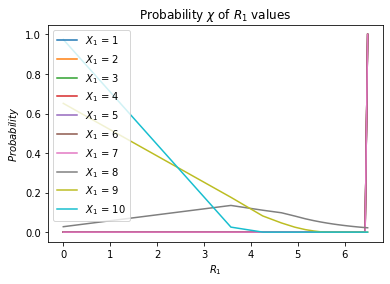

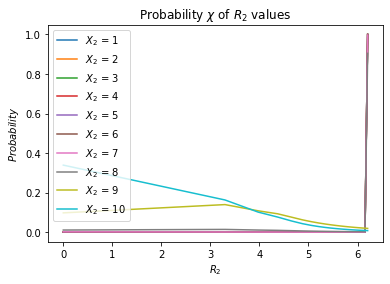

In [31]:
# Probability of R1 and R2 values
print('R1 =',R1)
plt.figure()
for i in range(1,K1+1):
    plt.plot(R1,Qui1[i*l1:(i+1)*l1], label='$X_1$ = {i}'.format(i=i))
plt.legend(loc = 'upper left')
plt.title('Probability $\chi$ of $R_1$ values ')
plt.xlabel('$R_1$')
plt.ylabel('$Probability$')

print('R2 =',R2)
plt.figure()
for i in range(1,K2+1):
    plt.plot(R2,Qui2[i*l2:(i+1)*l2], label='$X_2$ = {i}'.format(i=i))
plt.legend(loc = 'upper left')
plt.title('Probability $\chi$ of $R_2$ values ')
plt.xlabel('$R_2$')
plt.ylabel('$Probability$')

In [30]:
## The OMR Index Policy :

psi1 = []
psi2 = []
Pm = max(max(P1),max(P2))

for i in range(K1+1):
    psi1.append(np.matmul(C[i*l1:(i+1)*l1],Qui1[i*l1:(i+1)*l1]))

for i in range(K2+1):
    psi2.append(np.matmul(C[i*l2+l1*(K1+1):(i+1)*l2+l1*(K1+1)],Qui2[i*l2:(i+1)*l2]))

#psi1 = np.matmul(C[0:l1*(K1+1)],Qui[0:l1*(K1+1)])
#psi2 = np.matmul(C[l1*(K1+1):l1*(K1+1)+l2*(K2+1)],Qui[l1*(K1+1):l1*(K1+1)+l2*(K2+1)])
print('Psi_1(X_1) =', psi1)
print('Psi_2(X_2) =', psi2)

psi = []
for i in range(K1+1):
    for j in range(K2+1):
        if psi1[i] > psi2[j] :
            population = [k for k in range(l1)]
            weights = Qui1[i*l1:(i+1)*l1]
            index = max(choices(population,weights))
            P1_new = P1[index]
            P2_new = Pm - P1_new
        else :
            population = [k for k in range(l2)]
            weights = Qui2[i*l2:(i+1)*l2]
            index = max(choices(population,weights))
            P2_new = P2[index]
            P1_new = Pm - P2_new
        psi.append([P1_new,P2_new])

print(P1,P2)
#print(np.shape(psi))
psi = np.reshape(psi,(len(psi),2))
print('New allocated powers P1 and P2 :')
print(psi)
    

Psi_1(X_1) = [0.0, 0.9999999999999999, 2.0, 3.0, 4.0, 5.0, 6.000000000000001, 7.0, 7.999999999999999, 9.0, 10.0]
Psi_2(X_2) = [0.0, 0.9999999999999999, 2.0, 2.9999999999999996, 4.0, 5.0, 6.0, 7.0, 8.0, 9.000000000000002, 10.000000000000002]
[ 0.          0.57894737  1.15789474  1.73684211  2.31578947  2.89473684
  3.47368421  4.05263158  4.63157895  5.21052632  5.78947368  6.36842105
  6.94736842  7.52631579  8.10526316  8.68421053  9.26315789  9.84210526
 10.42105263 11.        ] [ 0.          0.57894737  1.15789474  1.73684211  2.31578947  2.89473684
  3.47368421  4.05263158  4.63157895  5.21052632  5.78947368  6.36842105
  6.94736842  7.52631579  8.10526316  8.68421053  9.26315789  9.84210526
 10.42105263 11.        ]
New allocated powers P1 and P2 :
[[11.          0.        ]
 [11.          0.        ]
 [11.          0.        ]
 [11.          0.        ]
 [ 2.31578947  8.68421053]
 [11.          0.        ]
 [11.          0.        ]
 [11.          0.        ]
 [ 7.52631579  3.473

In [31]:
P1 = psi[:,0]
P2 = psi[:,1]

#P1 = P1_Bellman
#P2 = P2_Bellman

# We assume the average cost is 0 at time t=0 (or t=T)
V0 = np.zeros((K1+1)*(K2+1))
moyV_IP = []
T_tot = 10000
diff = 10

eps = 0.01

#while diff > eps:
for t in range(T_tot):
    new_V = []
    for ind in range((K1+1)*(K2+1)):
        list_V = []   # matrix of V[ind] for every policy in a certain time slot t

        # values of the flow for devices 1 & 2
        r1 = flow(g1,P1[ind],delta)
        r2 = flow(g2,P2[ind],delta)

        # transition matrix :
        L = mat_L(mu1,r1,gamma,K2)
        R = mat_R(lambda1,gamma,K2)
        T0 = mat_theta0(mu2,r2,lambda1,lambda2,gamma,K2)
        T = mat_theta(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)
        TK = mat_thetaK(mu1,mu2,r1,r2,lambda1,lambda2,gamma,K2)
        M = mat_M(L,R,T0,T,TK,K1,K2)
        
        # solution :
        #print(V0)
        V = 1/(t+1)*X[ind] + t/(t+1)*np.matmul(M[ind],V0)
        new_V.append(V)

    diff = max(new_V)-min(new_V)
    V0 = new_V
    moyV_IP.append(np.mean(V0))

S2 = V0
print('Solution :')
print(S2)


Solution :
[7.997781895848981, 7.998676933348024, 7.999609451603793, 8.000467069975457, 8.001026551297752, 8.00403103282443, 8.00542176478212, 8.006636766974836, 8.007374145451909, 8.010457920967985, 8.011325663436523, 7.9994447845119385, 7.999983760328183, 8.000672597541984, 8.00150977203695, 8.002489160958302, 8.003605322398387, 8.00485320319498, 8.006227248177261, 8.00771689802333, 8.009280876326814, 8.010697780337809, 8.003239680761622, 8.004430131513574, 8.00554582176012, 8.006806882334125, 8.008179082623524, 8.009660653134192, 8.011249361184614, 8.012941661783053, 8.014727868006256, 8.016563633537212, 8.018201711648098, 8.008749936710801, 8.010517146171837, 8.012222324379062, 8.013920650873533, 8.0155277356948, 8.017235870181072, 8.019041371518131, 8.02093901004624, 8.022917127843826, 8.024927570874164, 8.026706141213003, 8.015525470866375, 8.017762599370414, 8.019898550479544, 8.02192030532373, 8.023732091866066, 8.025626937337922, 8.027602415068783, 8.029650498296057, 8.0317576

## Policy comparison : Bellman - OMR

Text(0.5, 1.0, 'Cost comparison of the solutions')

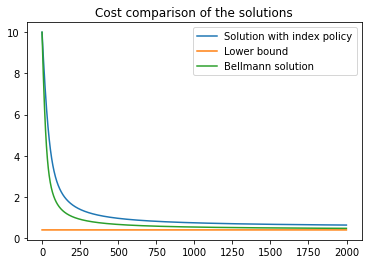

In [32]:
# Evolution of the cost for each solution

plt.figure()
plt.plot([i for i in range(T_tot)], moyV_IP, label='Solution with index policy')
plt.plot([i for i in range(T_tot)], problem.value*np.ones(T_tot), label='Lower bound')
plt.plot([i for i in range(T_tot)], moyV_B, label='Bellmann solution')
plt.legend()
plt.title('Cost comparison of the solutions')

In [35]:
## Average cost value comparison :

V_Bellmann = np.mean(S1)
V_OccMeasure = problem.value
V_IndexPolicy = np.mean(S2)
suboptimal = 100*(V_IndexPolicy-V_Bellmann)/V_Bellmann

print('Cost with Bellmann :',V_Bellmann)
print('Cost with Occupation Measure :',V_OccMeasure)
print('Cost with Index Policy :',V_IndexPolicy)
print('Suboptimality gap :',suboptimal)


Cost with Bellmann : 3.4110035448144287
Cost with Occupation Measure : 3.1105998494270843
Cost with Index Policy : 8.034430151070437
